In [1]:
# Parameters (default values will be overwritten by Papermill)
input_dir = "default_input_dir"
output_dir = "default_output_dir"
output_der = "default_output_der"
input_model_name = "default_input_model_name"
input_model_path = "default_model_save_path"

In [2]:
#model_name = "apple/mobilevit-xx-small"
model_name = "tiny_vit_5m_224"
model_save_path = f"models/tiny_vit_5m_224_2025-01-06_17-38.pth"
#model_save_path = f"models/apple_mobilevit-xx-small_2025-01-06_16-59.pth"

#model_name = input_model_name
#model_save_path = input_model_path


In [3]:
## Import Statements
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

import torch

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

import torch.optim as optim
import torch.nn as nn

from sklearn.metrics import f1_score

import os

import timm  # To use the TinyViT model

import matplotlib.pyplot as plt
from PIL import Image

import json
import os

# set constants
#SEED = 19
CLASSES_NO = 37

2025-01-30 19:19:07.937576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 19:19:08.156157: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 19:19:09.005873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-30 19:19:09.005962

## Start With Classifying without watermarks

In [4]:
num_classes = 37  # Update this if you have a different number of classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if model_name == "apple/mobilevit-xx-small":
    print("Using MobileViT")
    # Load the processor
    processor = AutoImageProcessor.from_pretrained(model_name)

    # Load the pretrained model
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    # Update the classifier to match the dataset classes
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

elif model_name == "tiny_vit_5m_224":
    print("Using TinyViT")
    # Import timm for TinyViT model loading
    import timm

    # Load the pretrained TinyViT model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)

else:
    raise ValueError("Unsupported model type. Please use MobileViT or TinyViT.")

# Load fine-tuned weights
try:
    model.load_state_dict(torch.load(model_save_path))
    print("Model weights loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError(f"Model weights not found at {model_save_path}")

# Move model to the appropriate device
model = model.to(device)
model.eval()  # Set the model to evaluation mode


Using TinyViT


/tmp/ipykernel_3330/121078527.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


Model weights loaded successfully.


TinyVit(
  (patch_embed): PatchEmbed(
    (conv1): ConvNorm(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): GELU(approximate='none')
    (conv2): ConvNorm(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (0): ConvLayer(
      (blocks): Sequential(
        (0): MBConv(
          (conv1): ConvNorm(
            (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act1): GELU(approximate='none')
          (conv2): ConvNorm(
            (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=256, bias=Fals

In [5]:
# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(           # Normalize with ImageNet statistics
        #mean=[0.485, 0.456, 0.406],
        mean = [0.4784, 0.4460, 0.39609],
        #std=[0.229, 0.224, 0.225]
        std = [0.2245, 0.2216, 0.2227] 
    )
])


In [6]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor).logits
            predicted_class = torch.argmax(outputs, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)


In [7]:
def classify_images_from_folder(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor)  # Get raw model output
            if isinstance(outputs, torch.Tensor):  # Check if it's a PyTorch model
                predicted_class = torch.argmax(outputs, dim=1).item()
            else:  # Assume it's a Hugging Face model output
                predicted_class = torch.argmax(outputs.logits, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)

In [8]:
# Define paths to the folders
test_folder = "./data/resized_images/test"
#trainval_folder = "./data/resized_images/trainval"

# Classify images in test folder
test_predictions = classify_images_from_folder(test_folder, model, transform, device)

# Classify images in trainval folder
#trainval_predictions = classify_images_from_folder(trainval_folder, model, transform, device)


In [9]:
# Load ground truth data
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display first few rows
print(pet_dataset_info.head())


       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [10]:
print(test_predictions.head())

           image_name  predicted_class
0    Abyssinian_2.jpg                0
1   Abyssinian_20.jpg                0
2  Abyssinian_201.jpg                0
3  Abyssinian_202.jpg                0
4  Abyssinian_204.jpg                0


In [11]:
# Adjust the predicted_class by subtracting 1
test_predictions["predicted_class"] = test_predictions["predicted_class"] + 1

# Merge test predictions with ground truth
test_predictions["image_name"] = test_predictions["image_name"].map(lambda x: x.replace(".jpg", ""))
test_comparison = pd.merge(test_predictions, pet_dataset_info, on="image_name", how="inner")

# Check if predictions match ground truth
test_comparison["is_correct"] = test_comparison["predicted_class"] == test_comparison["class"]

# Display comparisons
print(test_comparison[["image_name", "predicted_class", "class", "is_correct"]])


                image_name  predicted_class  class  is_correct
0             Abyssinian_2                1    1.0        True
1            Abyssinian_20                1    1.0        True
2           Abyssinian_201                1    1.0        True
3           Abyssinian_202                1    1.0        True
4           Abyssinian_204                1    1.0        True
...                    ...              ...    ...         ...
3664  yorkshire_terrier_95               37   37.0        True
3665  yorkshire_terrier_96               37   37.0        True
3666  yorkshire_terrier_97               37   37.0        True
3667  yorkshire_terrier_98               37   37.0        True
3668  yorkshire_terrier_99               31   37.0       False

[3669 rows x 4 columns]


In [12]:
# Save test predictions
test_comparison.to_csv("./data/test_predictions_comparison.csv", index=False)
print("Test predictions saved to ./data/test_predictions_comparison.csv")



Test predictions saved to ./data/test_predictions_comparison.csv


In [13]:

# Calculate accuracy for test data
test_accuracy = test_comparison["is_correct"].mean()
print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate F1 scores for test data
y_pred_test = test_comparison["predicted_class"]
y_true_test = test_comparison["class"]

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")

# Save results to a dictionary
test_metrics = {
    "test_accuracy": test_accuracy,
    "f1_test_weighted": f1_test_weighted,
    "f1_test_macro": f1_test_macro
}

# Define the output directory and file
output_dir = "output/test_metrics"
os.makedirs(output_dir, exist_ok=True)
metrics_path = os.path.join(output_dir, "test_metrics.json")

# Save the metrics to a JSON file
with open(metrics_path, "w") as f:
    json.dump(test_metrics, f, indent=4)

print(f"Test metrics saved to {metrics_path}")


Test Accuracy: 88.28%
Test F1 Score (Weighted): 0.8821
Test F1 Score (Macro): 0.8815
Test metrics saved to output/test_metrics/test_metrics.json


## Start With Classifying with watermarks




In [25]:
def classify_images(folder_path, model, transform, device):
    predictions = []

    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)

        # Skip non-image files
        if not image_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Open and preprocess the image
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Perform inference
        with torch.no_grad():
            outputs = model(input_tensor)  # Get raw model output
            if isinstance(outputs, torch.Tensor):  # Check if it's a PyTorch model
                predicted_class = torch.argmax(outputs, dim=1).item()
            else:  # Assume it's a Hugging Face model output
                predicted_class = torch.argmax(outputs.logits, dim=1).item()
            predictions.append({"image_name": image_name, "predicted_class": predicted_class})

    # Return predictions as a DataFrame
    return pd.DataFrame(predictions)


In [26]:
#Classify Test Images

# Path to test folder
test_folder = "./data/images_with_logos_5x/test"

# Classify images in the test folder
predictions_df = classify_images(test_folder, model, transform, device)

# Display predictions
print(predictions_df.head())



                 image_name  predicted_class
0   yorkshire_terrier_9.jpg               17
1  yorkshire_terrier_74.jpg               35
2  yorkshire_terrier_75.jpg               36
3  yorkshire_terrier_73.jpg               36
4  yorkshire_terrier_78.jpg               36


In [27]:

# Load ground truth data
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display the first few rows to verify
print(pet_dataset_info.head())



       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [28]:
#Compare Predictions with Ground Truth
# Merge predictions with ground truth
# Remove .jpg extension from image_name in predictions_df
predictions_df["image_name"] = predictions_df["image_name"].map(lambda x: x.replace(".jpg", ""))

comparison_df = pd.merge(predictions_df, pet_dataset_info, on="image_name", how="inner")


comparison_df["predicted_class"] = comparison_df["predicted_class"] + 1
# Add a comparison column
comparison_df["is_correct"] = comparison_df["predicted_class"] == (comparison_df["class"])  # Subtract 1 for 0-indexed classes

# Display comparison
print(comparison_df[["image_name", "predicted_class", "class", "is_correct"]])



                image_name  predicted_class  class  is_correct
0      yorkshire_terrier_9               18   37.0       False
1     yorkshire_terrier_74               36   37.0       False
2     yorkshire_terrier_75               37   37.0        True
3     yorkshire_terrier_73               37   37.0        True
4     yorkshire_terrier_78               37   37.0        True
...                    ...              ...    ...         ...
3664        Abyssinian_230                1    1.0        True
3665        Abyssinian_225                1    1.0        True
3666        Abyssinian_228                1    1.0        True
3667        Abyssinian_232                1    1.0        True
3668   yorkshire_terrier_8               37   37.0        True

[3669 rows x 4 columns]


In [29]:
# Calculate accuracy
accuracy = comparison_df["is_correct"].mean()
print(f"Accuracy: {accuracy:.2%}")


Accuracy: 81.06%


In [30]:
#import pandas as pd

# Load the pet_dataset_info.csv
pet_dataset_info = pd.read_csv("./data/pet_dataset_info.csv")

# Display the first few rows to verify
print(pet_dataset_info.head())

       image_name                                         image_path  class  \
0    Abyssinian_1    ./data/resized_images/trainval/Abyssinian_1.jpg    1.0   
1   Abyssinian_10   ./data/resized_images/trainval/Abyssinian_10.jpg    1.0   
2  Abyssinian_100  ./data/resized_images/trainval/Abyssinian_100.jpg    1.0   
3  Abyssinian_101  ./data/resized_images/trainval/Abyssinian_101.jpg    1.0   
4  Abyssinian_102  ./data/resized_images/trainval/Abyssinian_102.jpg    1.0   

       fold  
0  trainval  
1  trainval  
2  trainval  
3  trainval  
4  trainval  


In [31]:
# Save the comparison DataFrame to a CSV file
comparison_df.to_csv("./data/predictions_comparison.csv", index=False)

print("Predictions comparison saved to ./data/predictions_comparison.csv")



Predictions comparison saved to ./data/predictions_comparison.csv


In [32]:
#from sklearn.metrics import f1_score
# Calculate accuracy
accuracy = comparison_df["is_correct"].mean()
print(f"Accuracy: {accuracy:.2%}")

# For test data
y_pred_test = comparison_df["predicted_class"]
y_true_test = comparison_df["class"] 

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")




Accuracy: 81.06%
Test F1 Score (Weighted): 0.8102
Test F1 Score (Macro): 0.8095


In [33]:
# Calculate accuracy for test data
test_accuracy = comparison_df["is_correct"].mean()
print(f"Test Accuracy: {test_accuracy:.2%}")

# Calculate F1 scores for test data
y_pred_test = comparison_df["predicted_class"]
y_true_test = comparison_df["class"]

f1_test_weighted = f1_score(y_true_test, y_pred_test, average="weighted")
f1_test_macro = f1_score(y_true_test, y_pred_test, average="macro")

print(f"Test F1 Score (Weighted): {f1_test_weighted:.4f}")
print(f"Test F1 Score (Macro): {f1_test_macro:.4f}")

# Save results to a dictionary
test_metrics = {
    "prediction_accuracy": test_accuracy,
    "f1_test_weighted": f1_test_weighted,
    "f1_test_macro": f1_test_macro
}

# Define the output directory and file
output_der = "output/prediction_metrics"
os.makedirs(output_der, exist_ok=True)
metrics_path = os.path.join(output_der, "prediction_metrics.json")

# Save the metrics to a JSON file
with open(metrics_path, "w") as f:
    json.dump(test_metrics, f, indent=4)

print(f"Prediction metrics saved to {metrics_path}")

Test Accuracy: 81.06%
Test F1 Score (Weighted): 0.8102
Test F1 Score (Macro): 0.8095
Prediction metrics saved to output/prediction_metrics/prediction_metrics.json


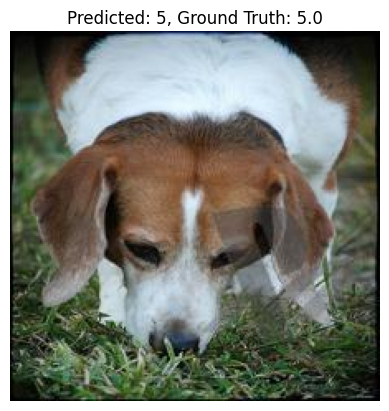

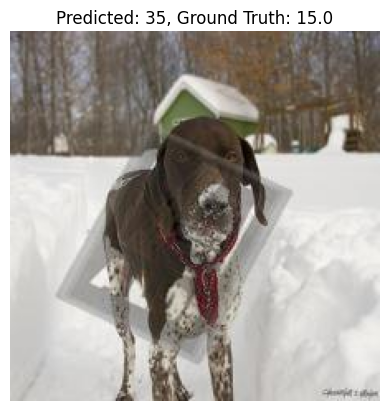

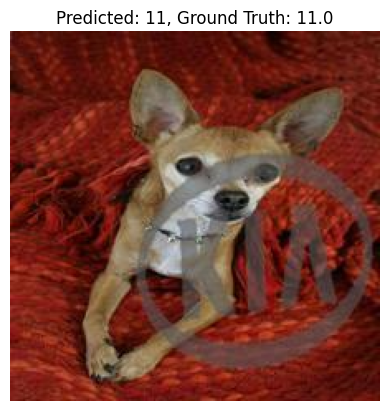

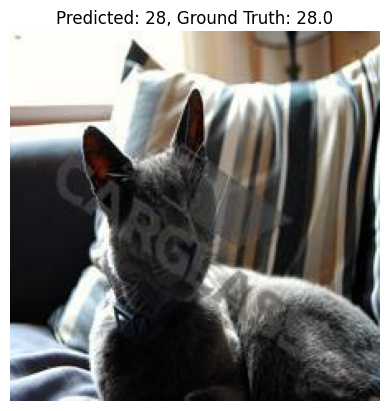

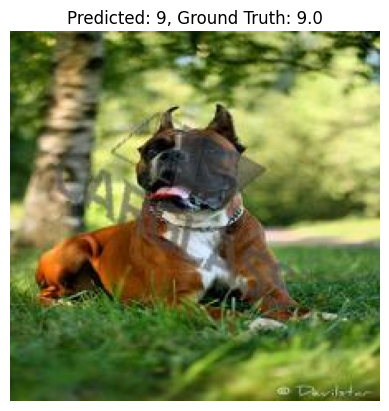

In [34]:
# Display 5 random classified images with labels
sampled_df = comparison_df.sample(5)
for _, row in sampled_df.iterrows():
    image_path = os.path.join(test_folder, f"{row['image_name']}.jpg")  # Adjust folder as needed
    image = Image.open(image_path)
    
    # Display the image inline
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {row['predicted_class']}, Ground Truth: {row['class']}")
    plt.show()


